In [1]:
%pylab inline

import sbibm
from sbids.tasks import lotka_volterra 

from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey

from numpyro.handlers import seed, trace, condition

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
task = sbibm.get_task("lotka_volterra")
reference_samples = jnp.array(task.get_reference_posterior_samples(num_observation=1))
observation = jnp.array(task.get_observation(num_observation=1).reshape([2, 10]).T) # Reordering for numpyro
truth = jnp.array(task.get_true_parameters(num_observation=1).flatten())

### Checking that the model seems plausible

In [5]:
fake_data = condition(lotka_volterra, {'z':jnp.array([30.0, 1.0]), 'theta':truth})
fake_data = seed(fake_data, PRNGKey(42))

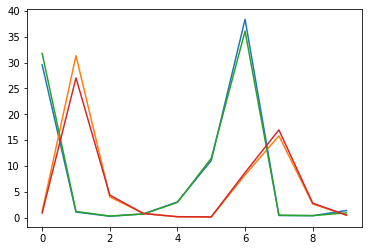

In [6]:
# Checking data is correctly aligned
d = fake_data()
plot(d);
plot(observation);

### Performing Inference

In [7]:
from numpyro.infer import MCMC, NUTS, Predictive
from chainconsumer import ChainConsumer

In [ ]:
# use dense_mass for better mixing rate
mcmc = MCMC(
    NUTS(lotka_volterra, dense_mass=True),
    num_warmup=1000,
    num_samples=10000,
    num_chains=1,
    progress_bar=True,
)
mcmc.run(PRNGKey(1), y=observation) 
mcmc.print_summary()

warmup:   3%|█▎                                       | 368/11000 [03:28<30:47,  5.75it/s, 7 steps of size 5.25e-01. acc. prob=0.78]

In [10]:
test_samples = mcmc.get_samples()

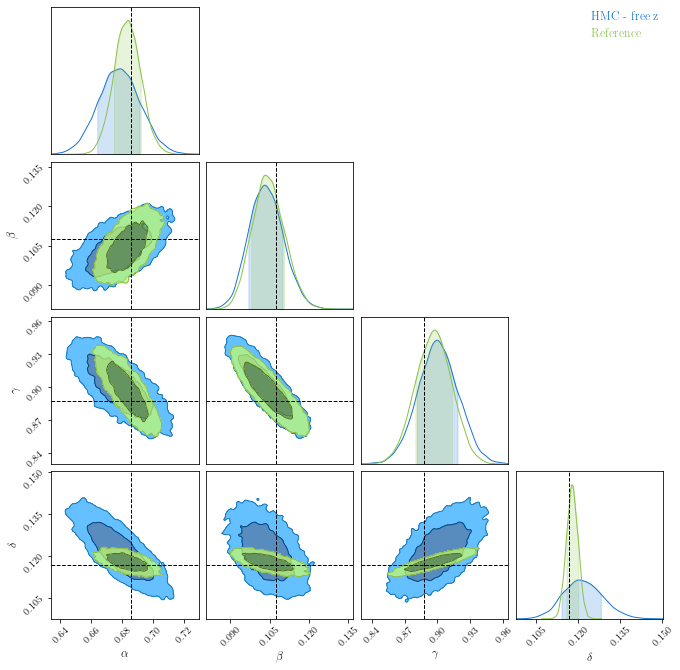

In [23]:
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()
c.add_chain(test_samples['theta'], parameters=parameters, name="HMC - free z")
c.add_chain(jnp.array(reference_samples), parameters=parameters, name="Reference")
fig = c.plotter.plot(figsize=[10,10], truth=[0.6859, 0.1076, 0.8879, 0.1168])

In [14]:
# Now, let'do the same thing but at fixed zinit
mcmc_fixed = MCMC(
    NUTS(condition(lotka_volterra, {'z': jnp.array([30.0, 1.0])}), 
         dense_mass=True),
    num_warmup=1000,
    num_samples=10000,
    num_chains=1,
    progress_bar=True,
)
mcmc_fixed.run(PRNGKey(3), y=observation) 
mcmc_fixed.print_summary()

sample: 100%|███████████████████████████████████████| 11000/11000 [20:43<00:00,  8.84it/s, 7 steps of size 5.16e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.68      0.01      0.68      0.67      0.70   8758.27      1.00
  theta[1]      0.10      0.01      0.10      0.09      0.11   8570.08      1.00
  theta[2]      0.90      0.02      0.90      0.87      0.92   8844.35      1.00
  theta[3]      0.12      0.00      0.12      0.11      0.12   9168.36      1.00

Number of divergences: 0


In [15]:
test_samples_fixed = mcmc_fixed.get_samples()

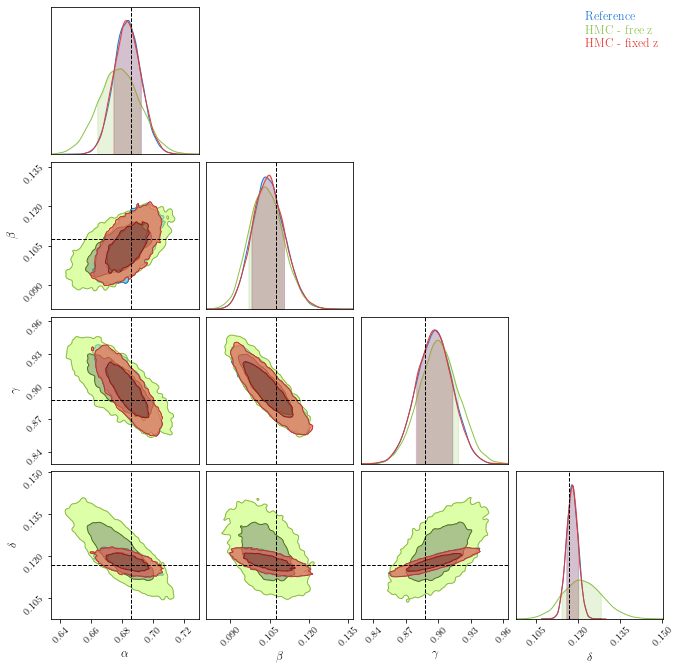

In [20]:
c = ChainConsumer()
c.add_chain(jnp.array(reference_samples), parameters=parameters, name="Reference")
c.add_chain(test_samples['theta'], parameters=parameters, name="HMC - free z")
c.add_chain(test_samples_fixed['theta'], parameters=parameters, name="HMC - fixed z")
fig = c.plotter.plot(figsize=[10,10], truth=[0.6859, 0.1076, 0.8879, 0.1168])

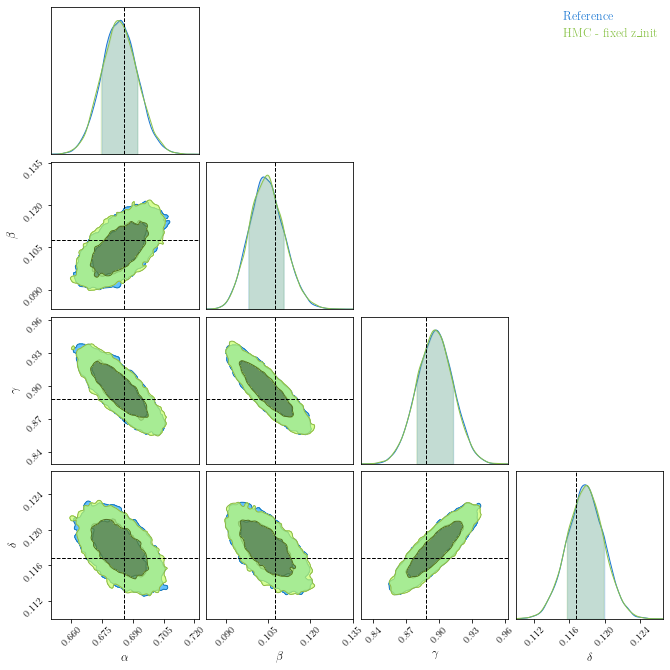

In [25]:
c = ChainConsumer()
c.add_chain(jnp.array(reference_samples), parameters=parameters, name="Reference")
c.add_chain(test_samples_fixed['theta'], parameters=parameters, name="HMC - fixed z_init")
fig = c.plotter.plot(figsize=[10,10], truth=[0.6859, 0.1076, 0.8879, 0.1168])